# Starter Notebook for GeneTuring Few-shot Evaluation

Let's start of by implementing a basic harness to evaluate the Geneturing dataset using Ollama with a Few-Shot prompting strategy to evaluate the performance of these models before implementing the tool-using strategies outlined in the GeneGPT paper.

As with most benchmarking code using pretrained models, our notebook will following typical outline of:

1. **Imports**
2. **Configuration**
3. **Data Loading**
4. **Model Specification**
5. **Metrics**
6. **Evaluation Loop**
7. **Analysis**

## 1. Imports

Good hygiene for Jupyter notebooks includes placing all of the imports at the top of the notebook. This makes it easier to understand what dependencies are needed to run the notebook for new users and mirrors good practices for Python scripts.

In [5]:
# 1.1 Place imports here
from typing import List, Optional

from collections import defaultdict
from dataclasses import dataclass
import os
from openai import AzureOpenAI
import json
import pandas as pd
from tqdm import tqdm
from typing import List, Callable

## 2. Configuration

Also, let's create a section that is specific to the configuration of the run. This will make it easier to change the configuration of the run without hunting for hard-coded values sprinkled throughout the code and makes it easier for others to understand the configuration of the run.

We will leave it empty at the moment, but we will come back and fill it in as we identify global configuration options that we need to implement the code.

In [2]:
# 2.1 Data Configuration


In [3]:
# 2.2 Model Configuration

In [6]:
# 2.3 Evaluation and Logging Configuration
AZURE_OPENAI_KEY="FJ5GrEV5LG3Y0UIeac29BIhmVu8GPcmWyeTTFH0cBifgT7T68XHPJQQJ99BEACHYHv6XJ3w3AAAAACOGdwHb"
AZURE_OPENAI_ENDPOINT="https://michaelholcomb-5866-resource.cognitiveservices.azure.com/"
AZURE_OPENAI_DEPLOYMENT_NAME="gpt-4.1"
AZURE_OPENAI_API_VERSION="2024-03-01-preview"

## 3. Data Loading

In this section we need to load the data that we will be using for our evaluation. 

The JSON file at `data/gene_turing.json` contains a dictionary of dictionaries. At the top level, the keys are the names of the tasks. Within each task, there are several key-value pairs where the keys are the questions and the values are the answers.

Below is one example for each of the 9 tasks in the dataset:

```json
{
    "Gene alias": {
        "What is the official gene symbol of LMP10?": "PSMB10"
    },
    "Gene disease association": {
        "What are genes related to Hemolytic anemia due to phosphofructokinase deficiency?": "PFKL"
    },
    "Gene location": {
        "Which chromosome is FAM66D gene located on human genome?": "chr8"
    },
    "Human genome DNA aligment": {
        "Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT": "chr15:91950805-91950932",
    },
    "Multi-species DNA aligment": {
        "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT": "worm",
    },
    "Gene name conversion": {
        "Convert ENSG00000215251 to official gene symbol.": "FASTKD5",
    },
    "Protein-coding genes": {
        "Is ATP5F1EP2 a protein-coding gene?": "NA",
    },
    "Gene SNP association": {
        "Which gene is SNP rs1217074595 associated with?": "LINC01270",
    },
    "SNP location": {
        "Which chromosome does SNP rs1430464868 locate on human genome?": "chr13",
    }
}
```


We need to reformat this into a pandas dataframe with the following columns:
- `id`: A serial ID number we will assign to each example (int)
- `task`: The name of the task (str)
- `question`: The question for the example (str)
- `answer`: The answer for the example (str)

The final dataframe we will create should look like this:

| id | task | question | answer |
|----|------|----------|--------|
| 0 | Task1 | Question1 | Answer1 |
| 1 | Task1 | Question2 | Answer2 |
| 2 | Task2 | Question1 | Answer1 |
| 3 | Task2 | Question2 | Answer2 |

In [7]:
# 3.1 Load the JSON file


with open("./data/geneturing.json", "r") as f:
    data = json.load(f)
# Load the data here

# Build the TASKS variable here

TASKS = set(data) 

In [8]:
TASKS

{'Gene SNP association',
 'Gene alias',
 'Gene disease association',
 'Gene location',
 'Gene name conversion',
 'Human genome DNA aligment',
 'Multi-species DNA aligment',
 'Protein-coding genes',
 'SNP location'}

In [9]:
# 3.2 Iterate through the JSON data recursively to collect each of the rows into a list
#     Each row should have a dictionary with keys of the columsn in the table above
rows = []

# Recursively iterate through each task and its Q&A pairs
for task, qas in data.items():
    for question, answer in qas.items():
        rows.append({
            "task": task,
            "question": question,
            "answer": answer
        })

# Preview first 3 rows
for row in rows[:3]:
    print(row)

{'task': 'Gene alias', 'question': 'What is the official gene symbol of LMP10?', 'answer': 'PSMB10'}
{'task': 'Gene alias', 'question': 'What is the official gene symbol of SNAT6?', 'answer': 'SLC38A6'}
{'task': 'Gene alias', 'question': 'What is the official gene symbol of IMD20?', 'answer': 'FCGR3A'}


In [10]:
# 3.3 Create the pandas dataframe from the collection of rows

df = pd.DataFrame(rows)

## 4. Model Specification

With our few-shot in-context learning model, we need to specify four components:

1. The large language model to use
2. The instructions for the model as a system prompt
3. The few-shot examples to provide to the model to demonstrate the input-output format
4. The completion request function that puts it all together retrieving a response for each unseen input

### 4.1 Setting up the large language model

We will use the Ollama client to interface with the large language model on the Ollama server we started. With large language models, it is common to use a client library to interface with the model hosted by a server. This allows us to iterate quickly on the prompting and post-processing logic without having to incur the overhead of loading the model into memory each time.  Additionally, model code is oftentimes optimized for inference.

In [11]:
# 4.1 Setting up the large language model Ollama model client
client = AzureOpenAI(
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_KEY,
)


### 4.2 Setting up the system prompt

Modern large language models are post-trained to perform a variety of tasks and follow instructions. To leverage this capability, we need to provide a system prompt that clearly outlines the task, any constraints, and the format of the output.

Designing the system prompt is a critical aspect of using LLMs. Below are several resources for designing a system prompt:
* [OpenAI Prompt Engineering](https://platform.openai.com/docs/guides/text?api-mode=responses#prompt-engineering)
* [Kaggle/Google Prompt Engineering](https://www.kaggle.com/whitepaper-prompt-engineering?_bhlid=a2bfce2cac67662098bd85a241e7cb000576e5d4)
* [Anthropic Prompt Engineering](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview)
* [OpenAI GPT 4.1 Prompting Cookbook](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)


**From the OpenAI Prompt Engineering guide:**

> **Identity**: Describe the purpose, communication style, and high-level goals of the assistant. 
> 
> **Instructions**: Provide guidance to the model on how to generate the response you want. What rules should it follow? What should the model do, and what should the model never do? This section could contain many subsections as relevant for your use case, like how the model should call custom functions.  
>
> **Examples**: Provide examples of possible inputs, along with the desired output from the model.  
> 
> **Context**: Give the model any additional information it might need to generate a response, like private/proprietary data outside its training data, or any other data you know will be particularly relevant. This content is usually best positioned near the end of your prompt, as you may include different context for different generation requests.  

This is what the system prompt looked like in the originalGeneGPT paper, but it is not the best. Identify what it includes and what is missing. Implement your own system prompt incorporating best practices from some of the guides posted above. 

> 	'Hello. Your task is to use NCBI Web APIs to answer genomic questions.'

In [23]:
# 4.2 Draft your own system prompt for our generic genomics question answering system. 
#     Replace the system message `content` below with your own.
system_message = [
    {
        "role": "system",
        "content": "Hello. Your task is to use NCBI Web APIs to answer genomic questions.Please only answer the question concisely and don't generate to many other stuff. If you can specify the answer, please put it after word Answer. If you are not sure about the answer, please try to be concise and give a brief guess based on the NCBI results."
    }
]

### 4.3 Setting up the few-shot examples

For tasks with idiosyncratic output formats or constraints, it is important to provide clear instructions as well as examples to guide the model in generating the desired output. Mechanically, we provide these pairs of inputs and outputs as a sequence of user and assistant messages after the system prompt.

```python
messages += [
    {
        "role": "user",
        "content":  <fill in input example 1>
    },
    {
        "role": "assistant",
        "content": <fill in output example 1>
    },
    {
        "role": "user",
        "content": <fill in input example 2>
    },
    {
        "role": "assistant",
        "content": <fill in output example 2>
    }
]
```

In the GeneGPT code, the authors included several tasks, one of each of a subset of the tasks in the dataset. We will use the same examples here.

Please inspect the GeneGPT repository to find the few-shot examples in the prompt. 

Specifically the `get_prompt_header` function in `main.py` located here: [main.py](https://github.com/ncbi/GeneGPT/blob/main/main.py)

In [24]:
response = client.chat.completions.create(
    messages=[
        { "role": "system","content": "You are a helpful assistant."},
        {"role": "user","content": "What is the official gene symbol of LMP10?",},
        {
            "role": "assistant",
            "content": "The official gene symbol of LMP10 is PSMB10.",
        },
        {
            "role": "user",
            "content": "What is the official gene symbol of SNAT6?",
        }
    ],
    max_tokens=800,  # fixed
    temperature=1.0,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
    model=AZURE_OPENAI_DEPLOYMENT_NAME
)

print(response.choices[0].message.content)


The official gene symbol of **SNAT6** is **SLC38A6**.


### 4.4 Implementing the model request function

Now we need to put it all together. We need a function that accepts as arguments:
1. The client
2. The system message
3. The few-shot examples
4. The new user query -- this case the user's question from the GeneTuring dataset.

The function should return the response from the model and extract the answer (everything after 'Answer :' based on the format of the examples above)



In [44]:
# 4.4 Implement THE model function

def query_model(
    client: AzureOpenAI, 
    system_message: dict, 
    few_shot_examples: List[dict], 
    user_query: str
) -> str:
    """
    Query the language model with few-shot examples and a user query.
    Returns the extracted answer string.
    """

    # Combine message components
    messages = system_message + few_shot_examples + [{"role": "user", "content": user_query}]

    # Call the model
    response = client.chat.completions.create(
        messages=messages,
        max_tokens=800,  # correct param name
        temperature=1.0,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0,
        model=AZURE_OPENAI_DEPLOYMENT_NAME
    )

    # Extract content
    response_content = response.choices[0].message.content.strip()

    # Try to extract the part after "Answer:" if present
    if "Answer:" in response_content:
        answer = response_content.split("Answer:")[-1].strip()
    else:
        answer = response_content  # fallback

    return answer

## 5. Metrics

The GeneTuring dataset has several task specific evaluation metrics that are variations on exact match depending on the expected cardinality of the output.

Please inspect `evaluate.py` from the GeneGPT repository to find the metric functions and implement them here.

Original functions: [evaluate.py](https://github.com/ncbi/GeneGPT/blob/main/evaluate.py)

* **Default exact match** - The predicted answers and ground truth are both strings. The score is 1 if they are equal and 0 otherwise
* **Gene disease association** - The predicted answers and ground truth are both lists of gene-disease associations. The score is the proportion of correct associations present in the prediction
* **Disease gene location** - The predicted and true answers are lists (e.g., gene locations related to a disease), and the evaluation calculates the fraction of the correct items present in the prediction.
* **Human genome DNA aligment** - 1 point for exact match, 0.5 point if chrX part matches, 0 otherwise

In [28]:
# 5.1 Implement metrics

def exact_match(pred: str, true: str) -> float:
    pred = pred.lower().strip()
    true = true.lower().strip()
    return float(true in pred)

def gene_disease_association(pred: List[str], true: List[str]) -> float:
    pred_set = set(map(str.strip, pred))
    true_set = set(map(str.strip, true))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)

def disease_gene_location(pred: List[str], true: List[str]) -> float:
    pred_set = set(map(str.strip, pred))
    true_set = set(map(str.strip, true))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)

def human_genome_dna_alignment(pred: str, true: str) -> float:
    # Assuming the format 'chrX:position1-position2'
    def extract_chromosome(s: str) -> str:
        return s.strip().split(':')[0] if ':' in s else s.strip()

    pred_chr = extract_chromosome(pred)
    true_chr = extract_chromosome(true)
    if pred_chr == true_chr:
        return 0.5 if pred.strip() != true.strip() else 1.0
    return 0.0

metric_task_map = defaultdict(lambda: exact_match, {
    "gene_disease_association": gene_disease_association,
    "disease_gene_location": disease_gene_location,
    "human_genome_dna_alignment": human_genome_dna_alignment
})


Many of the gold-answers are in a specific format. `evaluate.py` also implements an answer post-processing function `get_answer` to better align model outputs with the gold answers. We also need to implement a similar function.

In [29]:
import re

def get_answer(answer: str, task: str) -> str:
    answer = answer.strip()

    if task in ["Gene alias", "Gene location", "SNP location"]:
        # Extract last word that looks like a gene symbol (alphanumeric, all caps)
        match = re.findall(r"[A-Z0-9\-]+", answer)
        if match:
            return match[-1]  # Return last match (usually the actual symbol)
        else:
            return answer  # fallback

    elif task == "Gene disease association" or task == "Disease gene location":
        return answer.replace("Answer:", "").strip().split(', ')

    elif task == "Protein-coding genes":
        val = answer.replace("Answer:", "").strip()
        return "TRUE" if val == "Yes" else "NA"

    elif task == "Multi-species DNA aligment":
        mapper = {
            'Caenorhabditis elegans': 'worm',
            'Homo sapiens': 'human',
            'Danio rerio': 'zebrafish',
            'Mus musculus': 'mouse',
            'Saccharomyces cerevisiae': 'yeast',
            'Rattus norvegicus': 'rat',
            'Gallus gallus': 'chicken'
        }
        val = answer.replace("Answer:", "").strip()
        return mapper.get(val, val)

    else:
        return answer.replace("Answer:", "").strip()


In [30]:
# 5.2 Implement the answer mapping function 
def get_score(predictions: List[str], gold_answers: List[str], task: str) -> float:
    """
    Compute average score for a given task based on model predictions and ground truths.
    """
    assert len(predictions) == len(gold_answers), "Mismatched number of predictions and ground truths."

    correct = []

    for pred, gold in zip(predictions, gold_answers):
        pred_processed = get_answer(pred, task)
        gold_processed = get_answer(gold, task)

        # Get the appropriate metric function for this task
        metric_fn = metric_task_map[task]
        score = metric_fn(pred_processed, gold_processed)
        correct.append(score)

    return sum(correct) / len(correct) if correct else 0.0


## 6. Evaluation Loop

Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [31]:
# 6.1 Set up data structures for results

@dataclass
class Result:
    id: int
    task: str
    question: str
    answer: str
    prediction : str
    score: Optional[float]
    success: bool

def save_results(results: List[Result], results_csv_filename: str) -> None:
    df = pd.DataFrame(results)
    #df = pd.DataFrame([asdict(r) for r in results])
    df.to_csv(results_csv_filename, index=False)


In [47]:
# 6.2 Loop over the dataset with a progress bar

# * Do not forget to add the results to our Result list, both successful and failed predictions
# * API calls will not always work, so make sure we capture the exceptions from failed calls
#    and add them to the Result list with a `status=False`

def evaluate_dataset(df: pd.DataFrame, model_fn: Callable[[str], str]) -> (List[Result], dict, float):
    results: List[Result] = []
    task_scores = {}
    task_counts = {}

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        task = row["task"]
        question = row["question"]
        true_answer = row["answer"]
        
        try:
            # Call the model
            raw_pred = model_fn(question)

            # Post-process
            pred = get_answer(raw_pred, task)
            true = get_answer(true_answer, task)
            # print("="*60)
            # print(f"[{task}]")
            # print(f"Question: {question}")
            # print(f" True Answer: {true}")
            # print(f" Model Raw Output: {raw_pred}")
            # print(f"Processed Prediction: {pred}")
            # Score it
            metric_fn = metric_task_map[task]
            score = metric_fn(pred, true)
            success = True
            #print(f"[{task}] True: {true}, Pred: {pred}, Score: {score}")
        except Exception as e:
            raw_pred = f"[ERROR] {e}"
            score = 0.0
            success = False

        results.append(Result(
            id=idx,
            task=task,
            question=question,
            answer=true_answer,
            prediction=raw_pred,
            score=score,
            success=success
        ))

        if success:
            task_scores[task] = task_scores.get(task, 0.0) + score
            task_counts[task] = task_counts.get(task, 0) + 1
        
    # Compute average score per task
    for task in task_scores:
        task_scores[task] /= task_counts[task]

    # Compute overall average score
    overall_score = sum(task_scores.values()) / len(task_scores) if task_scores else 0.0

    return results, task_scores, overall_score



In [31]:
# 6.3 Save the results

In [48]:
# Dummy model for testing
def model_fn(question: str) -> str:
    return query_model(client, system_message, [], question)
#subset_df = df.head(20)  # First 20 rows only
results, task_scores, overall = evaluate_dataset(df, model_fn)
save_results(results, "gene_turing_results.csv")


print(f"Overall Score: {overall:.3f}")


100%|██████████████████████████████████████| 450/450 [04:51<00:00,  1.54it/s]

Overall Score: 0.215


## 7. Analysis

Now that we have collected the first round of GeneTuring results, let's analyze them. Let's start by calculating what fraction of predictions were successful.

In [53]:
# 7.1 Calculate the fraction of successful predictions
results_df = pd.DataFrame(results)
fraction_successful = results_df['score'].mean()
print(f"Fraction of successful predictions: {fraction_successful:.2%}")


Fraction of successful predictions: 19.11%


Now let's calculate both the overall score as well as the score by task.

In [54]:
# 7.2 Calculate the overall score and the score by task
print(f" Overall score: {overall:.3f}")
print(" Scores by task:")
for task, score in task_scores.items():
    print(f"  - {task}: {score:.3f}")

 Overall score: 0.215
 Scores by task:
  - Gene alias: 0.180
  - Gene location: 0.380
  - Human genome DNA aligment: 0.000
  - Multi-species DNA aligment: 0.140
  - Gene name conversion: 0.000
  - Protein-coding genes: 1.000
  - Gene SNP association: 0.000
  - SNP location: 0.020


Then, let's create a bar chart of the scores by task with a horizontal line for the overall score. Let's save the figure as well to our output directory.

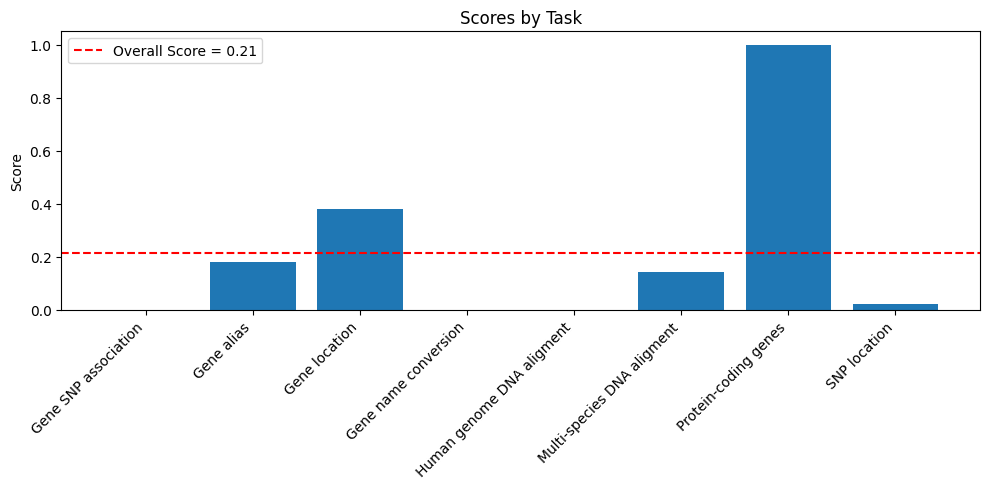

In [55]:
# 7.3 Create a bar chart of the scores by task with a horizontal line for the overall score
import matplotlib.pyplot as plt

# Sort tasks by name
sorted_tasks = sorted(task_scores.keys())
scores = [task_scores[task] for task in sorted_tasks]

plt.figure(figsize=(10, 5))
plt.bar(sorted_tasks, scores)
plt.axhline(y=overall, color='red', linestyle='--', label=f'Overall Score = {overall:.2f}')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Scores by Task')
plt.legend()
plt.tight_layout()
plt.show()
